In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime as dt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
file_path = r"C:\Users\12489\Documents\Data\air-passengers.csv"

data = pd.read_csv(file_path)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
data.info()

# always check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


--------------------------------

### let's make sure the 'Month' column has appropriate datetime syntax... (and set it to the index)

In [4]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))

""" not sure why simplilearn chose the 15th
 ...they don't mention in the tutorial"""

data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


------------------------------------

### now that the datetime is the index, we can plot timeseries

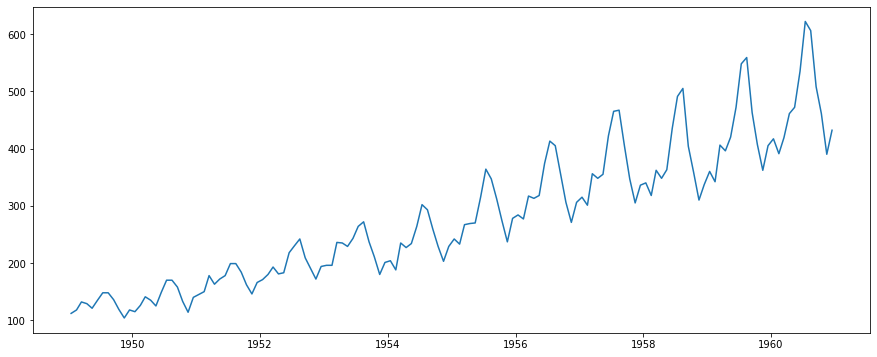

In [5]:
ts = data['#Passengers']

plt.plot(ts)

##### "it's clear from the plot that there is an overall increase in the **trend**, with some seasonality in it"

----------------------------------

### let's take a closer look at the trend, by transforming it...

### **(we will be writing functions for performing rolling statistics & tests)**

In [6]:
ts_log = np.log(ts)

In [7]:
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=52, center=False).mean()
    roll_stDev = timeseries.rolling(window=52, center=False).std()

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    stDev = plt.plot(roll_stDev, color='black', label='Rolling St.Dev')

    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    print("Results of Dickey-Fuller Test:")
    dFull_test = adfuller(timeseries, autolag='AIC')
    dFull_output = pd.Series(dFull_test[:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dFull_test[4].items():
        dFull_output['Critical Value (%s)'%key] = value

    print(dFull_output)

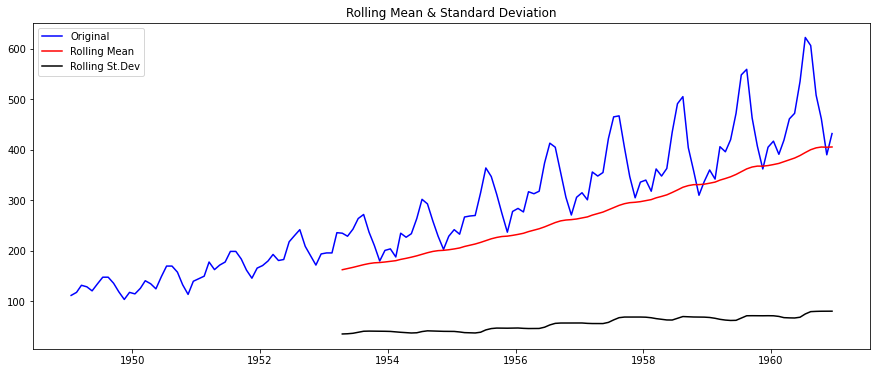

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
test_stationarity(data['#Passengers'])

##### "by observing the plot & the results of the Dickey-Fuller test, we can infer that the test statistics is more than Critical Value, and the "Moving Average" is not constant over time

##### **THEREFORE! The "Null Hypothesis" in this case cannot be rejected.**

-------------------------------------

### let's take a closer look, and see if we get better results by using the Moving Average/Mean

###### "...remove it using differencing in Python."

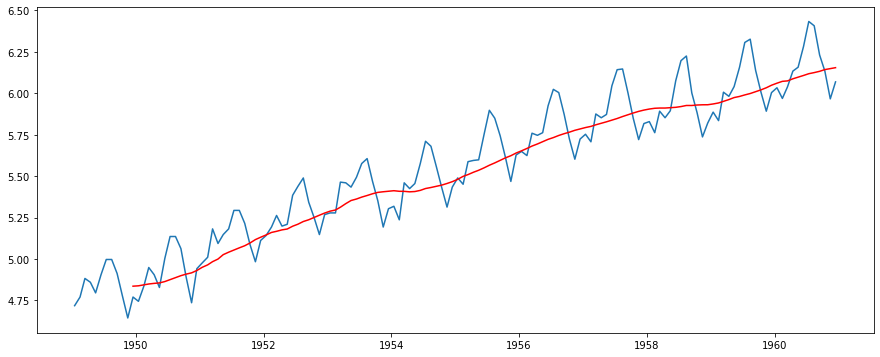

In [9]:
movingMean = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(movingMean, color = 'red')

In [11]:
ts_log_mv_diff = ts_log - movingMean

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head()

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
Name: #Passengers, dtype: float64

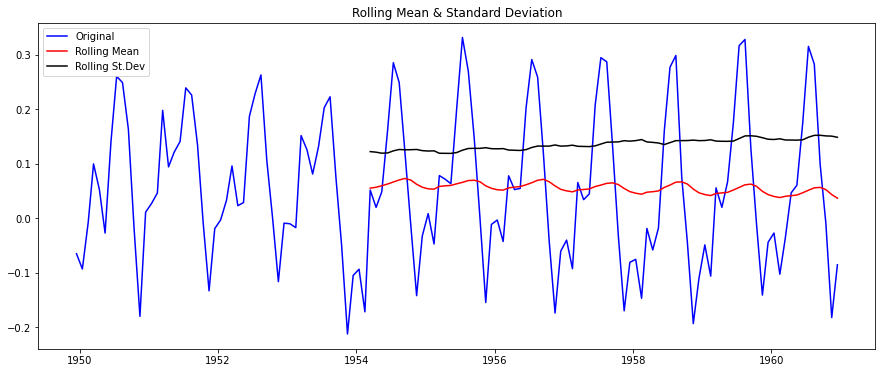

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [12]:
test_stationarity(ts_log_mv_diff)

##### "in **THIS** scenario, we can infer that the 'Test Statistic' is LESS than 'Critical Value (1%).' This tells us that we are 99% confident that this series is stationary."

##### **THEREFORE! YES! We can reject the "Null Hypothesis" in this case.**